In [1]:
import sqlite3

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from utils.masks_utils import idx_str_to_np_array, get_iou_for_mask_row, compute_mean_iou_for_predictions, plot_iou_box_per_kromp, plot_iou_cdfs, plot_iou_to_duration, plot_iou_to_area


params = {
    # "text.usetex": True,
    'axes.labelsize'  : 15.5,
    'font.family'     : 'sans-serif',
    'axes.titlesize'  : 15.5,
    'font.size'       : 14,
    'legend.fontsize' : 13,
    # 'legend.font.family' : 'sans-serif', nope this does not work
    'xtick.labelsize' : 13,
    'ytick.labelsize' : 13
}
plt.rcParams.update(params)

%matplotlib inline

PATH_TO_MASKS = 'postgres/20211004-074221_grab_cut_mask.csv'

NUMBER_OF_CELLS = {'Neuroblastoma_5': 18, 'Neuroblastoma_16': 16, 'Neuroblastoma_10': 16, 'Normal_2': 26, 'Normal_4': 15}

kromp_ids = ['neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4']
kromp_imgs = pd.api.types.CategoricalDtype(ordered=True, categories=kromp_ids)

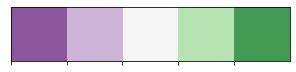

In [2]:
kromp_cmap = sns.color_palette("PRGn", 5)
sns.palplot(kromp_cmap)

## *RQ2*: How does providing manual constraints to the segmentation method affect the quality of the segmentation?

Quality metrics:

* IoU

In [3]:
computed_masks_dict = np.load('testimages_seg.npz')

In [4]:
conn = sqlite3.connect('grabcutstudy.db')
masks_df = pd.read_sql_query('''select * from maskchoiceinteractions''', conn)
conn.close()

In [5]:
masks_df['mask_arr'] = masks_df['mask'].apply(idx_str_to_np_array)
del masks_df['mask']

In [6]:
def has_id(x):
    return x in {'neurblas5', 'neurblas16', 'neurblas10', 'normal2', 'normal4'}

# kromp_masks_df = masks_df.loc[masks_df['image_id'] in kromp_ids]
masks_df = masks_df.assign(is_kromp_data=masks_df['image_id'].apply(has_id))
kromp_mask_df = masks_df[masks_df['is_kromp_data']]

In [7]:
gt = np.load('kromp_gt.npz')

neurblas5_gt = gt['neurblas5']
neurblas10_gt = gt['neurblas10']
neurblas16_gt = gt['neurblas16']
normal2_gt = gt['normal2']
normal4_gt = gt['normal4']

In [8]:
# don't do this
# kromp_mask_df['iou'] = kromp_mask_df.apply(iou, gt=gt, axis=1)
kromp_mask_df = kromp_mask_df.assign(iou=kromp_mask_df.apply(get_iou_for_mask_row, gt=gt, axis=1))

In [9]:
kromp_mask_df['image_id'] = kromp_mask_df['image_id'].astype(kromp_imgs)

In [10]:
kromp_mask_df.groupby(['image_id']).size()

image_id
neurblas5     15
neurblas10    11
neurblas16     9
normal2       14
normal4       13
dtype: int64

In [11]:
print(f'Number of masks for fluorescence test images {len(kromp_mask_df)}')

Number of masks for fluorescence test images 62


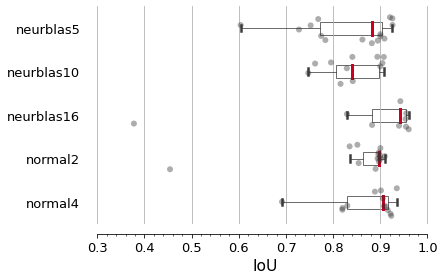

In [12]:
plot_iou_box_per_kromp(kromp_mask_df)

In [13]:
print('Median IoU of human annotators:')

Median IoU of human annotators:


In [14]:
print('IoU of automatic segmentations')

for id in kromp_ids:
    print(f'{id}:\t Box: {round(compute_mean_iou_for_predictions(computed_masks_dict[id][1], gt[id]), 3)}\t Adapt. thresh: {round(compute_mean_iou_for_predictions(computed_masks_dict[id][2], gt[id]), 3)}')

IoU of automatic segmentations
neurblas5:	 Box: 0.408	 Adapt. thresh: 0.796
neurblas10:	 Box: 0.428	 Adapt. thresh: 0.776
neurblas16:	 Box: 0.427	 Adapt. thresh: 0.876
normal2:	 Box: 0.539	 Adapt. thresh: 0.766
normal4:	 Box: 0.459	 Adapt. thresh: 0.877


In [15]:
import Cdf

In [16]:
neu5_ious = kromp_mask_df.loc[kromp_mask_df['image_id'] == 'neurblas5'].iou.values.tolist()
neu5_ious_cdf = Cdf.MakeCdfFromList(neu5_ious)

neu10_ious = kromp_mask_df.loc[kromp_mask_df['image_id'] == 'neurblas10'].iou.values.tolist()
neu10_ious_cdf = Cdf.MakeCdfFromList(neu10_ious)

neu16_ious = kromp_mask_df.loc[kromp_mask_df['image_id'] == 'neurblas16'].iou.values.tolist()
neu16_ious_cdf = Cdf.MakeCdfFromList(neu16_ious)

normal2_ious = kromp_mask_df.loc[kromp_mask_df['image_id'] == 'normal2'].iou.values.tolist()
normal2_ious_cdf = Cdf.MakeCdfFromList(normal2_ious)

normal4_ious = kromp_mask_df.loc[kromp_mask_df['image_id'] == 'normal4'].iou.values.tolist()
normal4_ious_cdf = Cdf.MakeCdfFromList(normal4_ious)

In [17]:
kromp_ids = ['neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4']
ious_cdfs = [neu5_ious_cdf, neu10_ious_cdf, neu16_ious_cdf, normal2_ious_cdf, normal4_ious_cdf]

def cdf_to_concat_df(cdf, category):
    xs, ps = cdf.Render()
    category_list = [category for i in range(len(xs))]
    return pd.DataFrame.from_dict({
        'xs': xs,
        'ps': ps,
        'image_id': category_list,
    })

ious_cdfs_df = pd.concat([cdf_to_concat_df(c, d) for d, c in zip(kromp_ids, ious_cdfs)]).reset_index(drop=True)

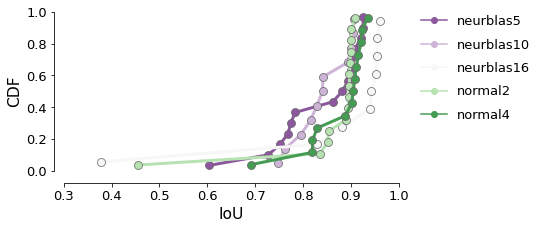

In [18]:
plot_iou_cdfs(ious_cdfs_df)

In [19]:
iou_x = 0.79
print(f'p_neu5(iou <= {iou_x}) = {neu5_ious_cdf.Prob(iou_x)}')
iou_x = 0.9
print(f'p_neu16(iou > {iou_x}) = {1 - neu16_ious_cdf.Prob(iou_x)}')

print(f'Smallest IoU: {min(neu16_ious_cdf.xs)}')

p_neu5(iou <= 0.79) = 0.4
p_neu16(iou > 0.9) = 0.6666666666666667
Smallest IoU: 0.3776095434732737


In [20]:
kromp_mask_df.groupby('image_id')['iou'].max()

image_id
neurblas5     0.925959
neurblas10    0.907481
neurblas16    0.960311
normal2       0.909625
normal4       0.935086
Name: iou, dtype: float64

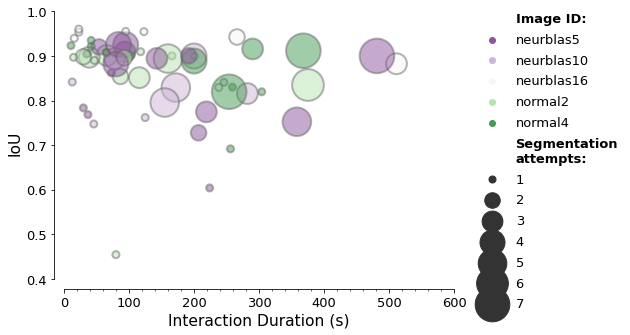

In [21]:
plot_iou_to_duration(kromp_mask_df)

/Users/stfnsu/Developer/msc-work/CP_DEV/grabcut-evaluation/utils/masks_utils.py:168: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(new_labels)


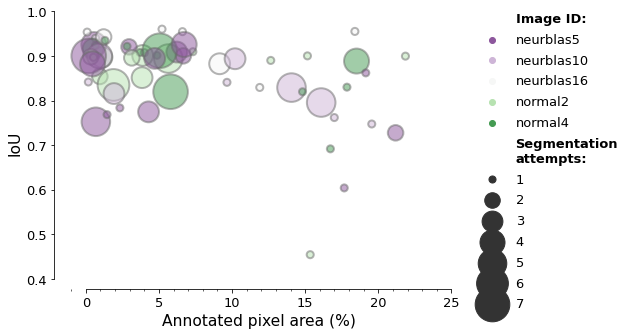

In [22]:
plot_iou_to_area(kromp_mask_df)

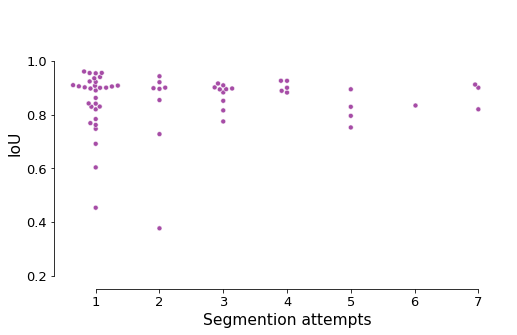

In [23]:
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
})

f, ax = plt.subplots(figsize=(8, 5))

g = sns.swarmplot(
    y="iou",
    x="total_submissions",
    color="Purple",
    size=5,
    linewidth=0.8,
    edgecolor='white',
    alpha=.7,
    data=kromp_mask_df, ax=ax,
)

ax.set(ylabel="IoU")
ax.set(xlabel="Segmention attempts")

ax.set_ylim([0.19, 1.2])

sns.despine(offset=10, trim=True)
plt.savefig(f"plots_png_higher_res/iou_attempts.png", dpi=1000, bbox_inches='tight')
plt.show()